In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.model_selection import StratifiedKFold  # Import for StratifiedKFold

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

Using GPU: Tesla P100-PCIE-16GB


In [4]:
# 資料集路徑
# dataset_folder = '/kaggle/input/esc50-adaf-spectrograms-8amplitude/ESC50_Adaf_Spectrograms_8(Amplitude)'
# dataset_folder = '/kaggle/input/esc50-adaf-spectrograms-16amplitude/ESC50_Adaf_Spectrograms_16(Amplitude)'
# dataset_folder = '/kaggle/input/esc50-adaf-spectrograms-32amplitude/ESC50_Adaf_Spectrograms_32(Amplitude)'
# dataset_folder = '/kaggle/input/esc50-adaf-spectrograms-64amplitude/ESC50_Adaf_Spectrograms_64(Amplitude)'
# dataset_folder = '/kaggle/input/esc50-adaf-spectrograms-128amplitude/ESC50_Adaf_Spectrograms_128(Amplitude)'
dataset_folder = '/kaggle/input/esc50-adaf-spectrograms-256amplitude/ESC50_Adaf_Spectrograms_256(Amplitude)'
# -------------------------------------------------------------------------------------------------
# dataset_folder = '/kaggle/input/esc50-adaf-spectrograms-128amplitude-max/ESC50_Adaf_Spectrograms_128(Amplitude)_max'
# dataset_folder = '/kaggle/input/esc50-adaf-spectrograms-128amplitude-mean/ESC50_Adaf_Spectrograms_128(Amplitude)_mean'
# dataset_folder = '/kaggle/input/esc50-adaf-spectrograms-128power/ESC50_Adaf_Spectrograms_128(Power)'
# dataset_folder = '/kaggle/input/esc50-adaf-spectrograms-128db/ESC50_Adaf_Spectrograms_128(DB)'
# -------------------------------------------------------------------------------------------------
# dataset_folder = '/kaggle/input/esc50-spectrogramsamplitude/ESC50_Spectrograms(Amplitude)'
# dataset_folder = '/kaggle/input/esc50-spectrogramspower/ESC50_Spectrograms(Power)'
# dataset_folder = '/kaggle/input/esc50-spectrogramsdb/ESC50_Spectrograms(DB)'
#-------------------------------------------------------------------------------------------------
# dataset_folder = '/kaggle/input/esc50-mel-spectrograms-128/ESC50_Mel_Spectrograms_128'
#-------------------------------------------------------------------------------------------------
meta_csv_path = '/kaggle/input/esc50-infor/esc50.csv'

In [5]:
import torchvision

class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()
    self.net = torchvision.models.efficientnet_b0(weights = "DEFAULT")

      
    
    # 將預訓練的第一層權重平均，適配成單通道
    original_weights = self.net.features[0][0].weight.detach().clone()  # 取得原始權重
    new_weights = original_weights.mean(dim=1, keepdim=True)  # 計算平均權重
      
    # 修改 EfficientNet 的第一層卷積層，將輸入通道數從 3 改為 1
    self.net.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    # self.net.features[0][0] = nn.Conv2d(1, 32, kernel_size=(128, 3), stride=(1, 1), padding=(0, 1), bias=False)
      
    self.net.features[0][0].weight = nn.Parameter(new_weights)  # 將新權重設置為第一層的權重

    in_features = self.net.classifier[1].in_features  
    self.net.classifier = nn.Sequential(
            nn.Linear(in_features, 128),  
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(128, 50),  
        )

  def forward(self, x):
    return self.net(x)

In [6]:
class SpectrogramDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # 轉為灰階
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [7]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor()
])

In [8]:
try:
    meta_df = pd.read_csv(meta_csv_path)
    print(f"Successfully loaded {meta_csv_path}")
except FileNotFoundError:
    print(f"ERROR: The metadata file was not found at {meta_csv_path}")
    print("Please update the 'meta_csv_path' variable to the correct path of your esc50.csv file.")
    exit()

Successfully loaded /kaggle/input/esc50-infor/esc50.csv


In [9]:
meta_df['image_path'] = meta_df['filename'].apply(
    lambda f: os.path.join(dataset_folder, f.replace('.wav', '.png'))
)

In [10]:
first_image = meta_df['image_path'].iloc[0]
if not os.path.exists(first_image):
    print(f"WARNING: The generated image path does not exist: {first_image}")
    print("Please verify that your image files in 'dataset_folder' have names that match the 'filename' column in the CSV (with .png extension).")

In [11]:
# Store metrics for each fold
fold_train_losses = []
fold_val_losses = []
fold_train_accuracies = []
fold_val_accuracies = []
fold_auc_scores = []

In [12]:
for fold_num in sorted(meta_df['fold'].unique()):
    print(f"\n=== Fold {fold_num}/5 ===")
    # print("all_labels type:", type(all_labels))
    # print("all_labels[:5]:", all_labels[:5])
    # print("train_idx[:5]:", train_idx[:5])

    # 根據 fold 號碼分割數據
    train_df = meta_df[meta_df['fold'] != fold_num]
    val_df = meta_df[meta_df['fold'] == fold_num]

    train_images = train_df['image_path'].values
    train_labels = train_df['target'].values
    val_images = val_df['image_path'].values
    val_labels = val_df['target'].values

    train_dataset = SpectrogramDataset(train_images, train_labels, transform=transform)
    val_dataset = SpectrogramDataset(val_images, val_labels, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    model = CNNModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    num_epochs = 25
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    auc_scores = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            labels = labels.long().view(-1).to(device)
            images = images.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_accuracy = correct / total
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        all_true = []
        all_probs = []

        with torch.no_grad():
            for images, labels in val_loader:
                labels = labels.long().view(-1).to(device)
                images = images.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                predicted = torch.argmax(outputs, dim=1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                all_true.extend(labels.cpu().numpy())
                all_probs.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

        val_accuracy = correct / total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)
        
        auc = roc_auc_score(all_true, all_probs, multi_class='ovo', average='macro')
        auc_scores.append(auc)
        scheduler.step(val_losses[-1])

        # Print metrics for each epoch
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}, AUC: {auc:.4f}, '
              f'Learning Rate: {optimizer.param_groups[0]["lr"]:.8f}')

     # 儲存當前 fold 訓練完成後的模型
    model_path = f'ESC-50_Adaf_Spectrograms_256(Amplitude)_5fold_{fold_num}.pth'
    torch.save(model.state_dict(), model_path)
    print(f"--- Model for Fold {fold_num} saved to {model_path} ---")
    
    # Store final epoch metrics
    fold_train_losses.append(train_losses[-1])
    fold_val_losses.append(val_losses[-1])
    fold_train_accuracies.append(train_accuracies[-1])
    fold_val_accuracies.append(val_accuracies[-1])
    fold_auc_scores.append(auc_scores[-1])


=== Fold 1/5 ===


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 160MB/s]


Epoch 1/25, Train Loss: 3.1198, Train Accuracy: 0.2338, Val Loss: 3.4022, Val Accuracy: 0.2050, AUC: 0.8103, Learning Rate: 0.00100000
Epoch 2/25, Train Loss: 1.6159, Train Accuracy: 0.5519, Val Loss: 1.9756, Val Accuracy: 0.4950, AUC: 0.9483, Learning Rate: 0.00100000
Epoch 3/25, Train Loss: 1.0438, Train Accuracy: 0.7031, Val Loss: 1.3702, Val Accuracy: 0.5800, AUC: 0.9764, Learning Rate: 0.00100000
Epoch 4/25, Train Loss: 0.8318, Train Accuracy: 0.7694, Val Loss: 1.2321, Val Accuracy: 0.6400, AUC: 0.9808, Learning Rate: 0.00100000
Epoch 5/25, Train Loss: 0.5744, Train Accuracy: 0.8313, Val Loss: 1.0452, Val Accuracy: 0.7000, AUC: 0.9854, Learning Rate: 0.00100000
Epoch 6/25, Train Loss: 0.5037, Train Accuracy: 0.8444, Val Loss: 1.2541, Val Accuracy: 0.7000, AUC: 0.9776, Learning Rate: 0.00100000
Epoch 7/25, Train Loss: 0.4171, Train Accuracy: 0.8731, Val Loss: 1.1249, Val Accuracy: 0.7400, AUC: 0.9813, Learning Rate: 0.00100000
Epoch 8/25, Train Loss: 0.3684, Train Accuracy: 0.8994,

In [13]:
mean_train_loss = np.mean(fold_train_losses)
std_train_loss = np.std(fold_train_losses)
mean_val_loss = np.mean(fold_val_losses)
std_val_loss = np.std(fold_val_losses)

mean_train_acc = np.mean(fold_train_accuracies)
std_train_acc = np.std(fold_train_accuracies)
mean_val_acc = np.mean(fold_val_accuracies)
std_val_acc = np.std(fold_val_accuracies)

mean_auc = np.mean(fold_auc_scores)
std_auc = np.std(fold_auc_scores)

# Print final results
print("Cross-Validation Results:")

print(f"Average Train Loss:     {mean_train_loss:.4f} ± {std_train_loss:.4f}")
print(f"Average Validation Loss:  {mean_val_loss:.4f} ± {std_val_loss:.4f}")

print(f"Average Train Accuracy:   {mean_train_acc*100:.2f} ± {std_train_acc*100:.2f} %")
print(f"Average Validation Acc:   {mean_val_acc*100:.2f} ± {std_val_acc*100:.2f} %")
print(f"Average Validation AUC:   {mean_auc:.2f} ± {std_auc:.2f}")
print(f"Average Validation AUC:   {mean_auc:} ± {std_auc:}")

Cross-Validation Results:
Average Train Loss:     0.0140 ± 0.0031
Average Validation Loss:  0.8725 ± 0.2277
Average Train Accuracy:   99.71 ± 0.13 %
Average Validation Acc:   81.15 ± 4.12 %
Average Validation AUC:   0.99 ± 0.01
Average Validation AUC:   0.9902895408163266 ± 0.00531906810944309


In [14]:
# 計算訓練集各類別的張數
train_class_counts = {}
for _, label in train_dataset:
    train_class_counts[label] = train_class_counts.get(label, 0) + 1

# 印出各類別的張數
print("訓練集各類別的張數:")
for label, count in train_class_counts.items():
    print(f"類別 {label}: {count} 張")

# 計算測試集各類別的張數
test_class_counts = {}
for _, label in val_dataset:
    test_class_counts[label] = test_class_counts.get(label, 0) + 1

# 印出各類別的張數
print("測試集各類別的張數:")
for label, count in test_class_counts.items():
    print(f"類別 {label}: {count} 張")

訓練集各類別的張數:
類別 0: 32 張
類別 14: 32 張
類別 36: 32 張
類別 19: 32 張
類別 30: 32 張
類別 34: 32 張
類別 9: 32 張
類別 22: 32 張
類別 48: 32 張
類別 41: 32 張
類別 47: 32 張
類別 31: 32 張
類別 17: 32 張
類別 45: 32 張
類別 8: 32 張
類別 15: 32 張
類別 46: 32 張
類別 37: 32 張
類別 32: 32 張
類別 16: 32 張
類別 25: 32 張
類別 4: 32 張
類別 3: 32 張
類別 27: 32 張
類別 43: 32 張
類別 12: 32 張
類別 40: 32 張
類別 29: 32 張
類別 10: 32 張
類別 7: 32 張
類別 26: 32 張
類別 6: 32 張
類別 44: 32 張
類別 23: 32 張
類別 20: 32 張
類別 49: 32 張
類別 24: 32 張
類別 39: 32 張
類別 28: 32 張
類別 18: 32 張
類別 2: 32 張
類別 35: 32 張
類別 38: 32 張
類別 21: 32 張
類別 1: 32 張
類別 11: 32 張
類別 42: 32 張
類別 5: 32 張
類別 33: 32 張
類別 13: 32 張
測試集各類別的張數:
類別 2: 8 張
類別 42: 8 張
類別 16: 8 張
類別 35: 8 張
類別 27: 8 張
類別 20: 8 張
類別 4: 8 張
類別 18: 8 張
類別 19: 8 張
類別 48: 8 張
類別 33: 8 張
類別 5: 8 張
類別 41: 8 張
類別 26: 8 張
類別 40: 8 張
類別 24: 8 張
類別 46: 8 張
類別 43: 8 張
類別 10: 8 張
類別 36: 8 張
類別 12: 8 張
類別 21: 8 張
類別 45: 8 張
類別 3: 8 張
類別 1: 8 張
類別 7: 8 張
類別 8: 8 張
類別 11: 8 張
類別 38: 8 張
類別 0: 8 張
類別 29: 8 張
類別 13: 8 張
類別 32: 8 張
類別 17: 8 張
類別 22: 8 張
類別 44: 8 張


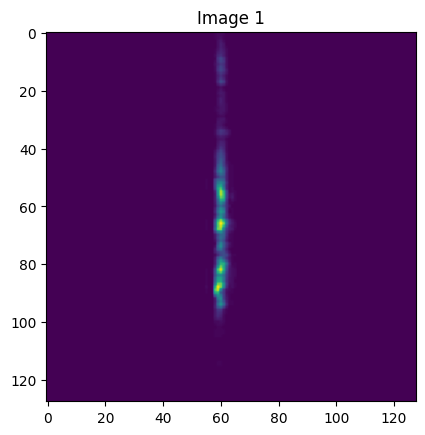

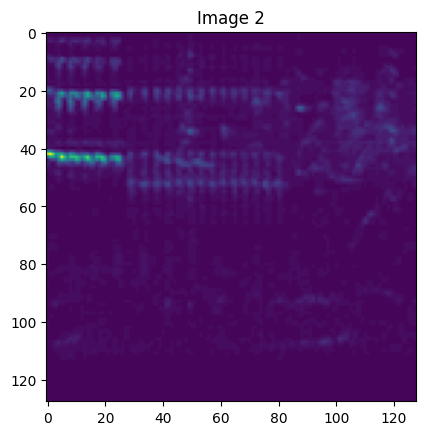

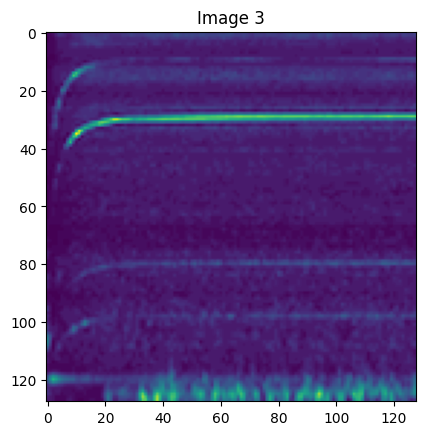

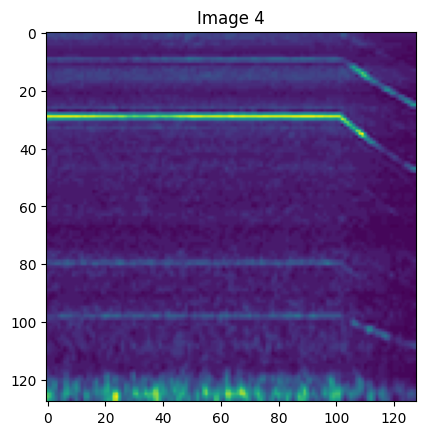

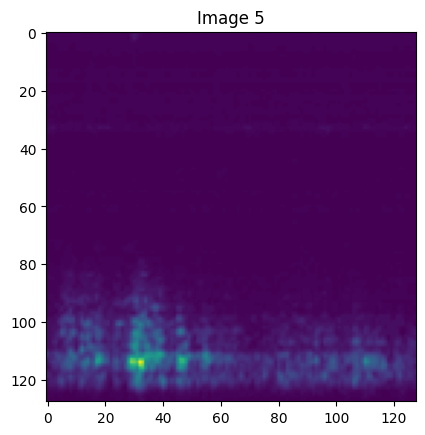

In [15]:
# Display
for i in range(5):
    image, _ = train_dataset[i]
    np_image = image.permute(1, 2, 0).numpy()
    plt.imshow(np_image)
    plt.title(f"Image {i+1}")
    plt.show()